In [1]:
import numpy as np
import cv2
import scipy.optimize as opt
import math
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
#np.set_printoptions(precision=None, suppress=True)
np.set_printoptions(suppress=True)


In [169]:
#number of matching points
N = 8
n_images = 4
F = np.zeros((n_images,n_images,3,3))
# true_K = np.array([
#     [5,0,2],
#     [0,5,2],
#     [0,0,1]
#     ])
true_K = np.array([
    [800,0,256],
    [0,800,256],
    [0,0,1]
    ])
I = np.array([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,0]
    ])

In [3]:
def calc_fund_matrix(points1,points2):
    '''
    Takes in 2 arrays of matching points 
    Return Fundamental matrix computes 
    using 8 point algorithm
    '''
#     F, mask = cv2.findFundamentalMat(points1,points2,cv2.FM_8POINT)
    F, mask = cv2.findFundamentalMat(points1,points2)

    return F 

In [4]:
def normalize_coordinates(p):
    # Normalization matrix
    T_m = normalization_matrix(p)
    # Normalized points
    p_norm = (T_m@(p.T)).T
    return p_norm, T_m

    
def manual_find_F_matrix(xy1,xy2):
    # Input: xy1 , xy2 - 2d array of points: row per point [x,y]
    # xy1 - for image 1, xy2 - for image 2
    # FM compute fundametal matrix from point correspondence
    #    at least 8 points are needed
    
    n_points = xy1.shape[0]
    if n_points < 8:
        print('8 points at least are needed')
    
    #add 3rd coordinate '1'
    xy1 = projectivation(xy1)
    xy2 = projectivation(xy2)
    
    
    #normalize coordinates
    xy1_norm, T1 = normalize_coordinates(xy1)
    xy2_norm, T2 = normalize_coordinates(xy2)
    
    # Preparing the equation matrix
    M = np.zeros((n_points,9))
    M[:,0] = xy1_norm[:,0]*xy2_norm[:,0] # x1 * x2
    M[:,1] = xy1_norm[:,0]*xy2_norm[:,1] # x1 * y2 
    M[:,2] = xy1_norm[:,0] # x1
    M[:,3] = xy1_norm[:,1]*xy2_norm[:,0] # y1 * x2
    M[:,4] = xy1_norm[:,1]*xy2_norm[:,1] # y1 * y2
    M[:,5] = xy1_norm[:,1] # y1
    M[:,6] = xy2_norm[:,0] # x2
    M[:,7] = xy2_norm[:,1] # y2
    M[:,8] = 1

    # calc M^T * M to get symmetruc square matrix
    W = M.T@M
    
    # desompose W into U (singular values), D (diagonal matrix), Vt (singular vectors)
    U,D,Vt = np.linalg.svd(W,compute_uv=True)
    a = U[:,-1]     # solution vector corresponding to the 
                    # least singular value
    A = np.reshape(a.T,(3,3))

    # Returning to non-normalized points
    F = np.linalg.inv(T2)@A@T1

    return F

In [5]:
### function used in class
def projectivation(p):
    '''
    Input: p, Nxd matrix = N points in R^d
    Output: q, Nx(d+1) = N points in P^d
    '''
    N,d = p.shape
    q = np.ones((N,d+1))
    q[:,0:d] = p 
    return q 

def affinization(q):
    '''
    Input: q, Nx(d+1) = N points in P^d
    Output: p, Nxd matrix = N points in R^d
    '''
    N,d1 = q.shape
    d = d1-1
    p = np.ones((N,d))
    p = q[:,0:d]/q[:,d:d+1] 
    
    return p

def normalization_matrix(p):
    '''
    Input: p: Nx2 matrix
    Output: T, normalization matrix (in projective plane) 
    '''

    # Computation
    m = np.mean(p,axis=0)
    q = p - np.repeat(m[np.newaxis,:],N,axis=0)
    w = np.sqrt(np.sum(q**2,axis=1))
    scale = 1/np.mean(w)

    # Normalization matrix
    T = np.zeros((3,3))
    T[2,2] = 1
    T[0,0] = scale
    T[0,2] = -m[0]*scale
    T[1,1] = scale
    T[1,2] = -m[1]*scale
        
    return T

In [271]:
def mendonca_cost_func(X):
    '''
    computes Mendonca & Cipolla Cost function to find the Optimal Intrinsic Parameters
    Input
    X      - Approximate Values of Intrinsics - 1D array with length 5
    Output
    E    - Computed Cost
    '''

    #Transform Intrinsics to Matrix Form
#     K = np.array([
#         [X[0],X[1],X[2]],
#         [0,X[3],X[4]],
#         [0,0,1]
#     ])
    K = np.array([
        [X[0],0,X[1]],
        [0,X[2],X[3]],
        [0,0,1]
    ])
    #Initialize Cost
    E = 0
    '''
       F - globally defined Fundamental Matrix between given two Images (F[i,j,3x3])
    '''
    # For the Denominator term of Mendonca & Cipolla's Equation
#     nof_images = len(F[0]) #number of images given
    nof_images = numberOfViews
    Den = nof_images*(nof_images-1)/2 # For N Images there are N(N-1)/2 Fundamental Matrices
  # 0 1 2 3 [0-1, 0-2,0-3, 1-2,1-3,2-3]
    # i  j
    # 0 -1 
    # 0 -2
    # 0 -3
    # 1- 2
    # 1 -3
    # 2 -3
  # len =4

    #Compute the Cost using Mendonca & Cipolla's Equation
    for i in range(0,nof_images-1):
        for j in range (i+1,nof_images):

            # Compute the Essential Matrix 'EM' from Fundamental of images i,j
#             EM = K.T @ F[i,j,:,:] @ K
            EM = K.T @ Fs[:,:,i,j] @ K

            # Compute SVD of Essential Matrix
            _,D,_ = np.linalg.svd(EM)
             # Singular Values (3rd value, D[3] is 0 according to theorem)
            r = D[0]
            s = D[1]
            
            #  Compute Cost

            E+= (1/Den) * (r - s)/s

    return E


In [216]:
def p3t(T,x,y,z):
    # apply a Projective 3D Transform
#     print(x.shape)
    xyz = np.concatenate((x, y, z),axis=1)
#     print(xyz)
#     print("np.concatenate((xyz,column_ones),axis=1)")
    column_ones = np.ones((len(x),1))
#     print(np.concatenate((xyz,column_ones),axis=1))
    tmp = T @ (np.concatenate((xyz,column_ones),axis=1)).T
    xp = (tmp[0,:]/tmp[3,:]).T
    yp = (tmp[1,:]/tmp[3,:]).T
    zp = (tmp[2,:]/tmp[3,:]).T
    return xp,yp,zp

In [237]:
def projf(P,x,y,z):
#     % PROJ  compute perspective projection (from 3D to pixel coordinates)
#     %   pixel positions are returned with floating point precision
#     %
#     %   See also PROJE
    print("P\n",P.shape)
    c3d = np.concatenate((x, y, z),axis=1)
    print("c3d\n",c3d.shape)
    column_ones = np.ones((len(x),1))
    h3d = (np.concatenate((c3d,column_ones),axis=1)).T
    print("h3d\n",h3d.shape)
    h2d = P @ h3d
    print("h2d.shape\n",h2d.shape)
    print("h2d\n",h2d)

    c2d = h2d / h2d[2,:]

    u = c2d[0,:].T
    v = c2d[1,:].T
    return u,v

In [167]:
def plot_3d(x,y,z):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x,y,z)
    plt.show()

In [245]:
def plot_2d(x,y):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(x,y)
    plt.show()

In [222]:
def conver_to_col(x):
    return np.reshape(x,(len(x),1))

In [177]:
def rcam(A):
# RCAM generate a random camera
#    generate a random camera pointing to lookp, positioned at an average 
#    distance ad form the origin, with a std dev of sd 
#    A is the intrinsic parameters matrix

    ad=2.5
    sd=0.25
    lookp=np.zeros((1,3))
    eyep = np.random.uniform(-1,1,size=(1,3))-0.5
    R = np.zeros((3,3))
    eyep = eyep/np.linalg.norm(eyep) * (ad + sd*np.random.randint(1))
#     print(eyep)
    R[2,:] = lookp - eyep/np.linalg.norm(lookp - eyep)
    R[1,:] = np.cross(R[2,:],np.random.uniform(size=(1,3)))
    R[1,:] = R[1,:]/np.linalg.norm(R[1,:])
    R[0,:] = np.cross(R[1,:],R[2,:])
    Rt = np.concatenate((R,-R @ eyep.T),axis=1)
#     print(np.matrix(Rt))
    return A @ Rt


In [240]:
numberOfViews=5
numberOfPoints = 50
imagePoints = np.zeros((numberOfPoints,2,numberOfViews))
PPM = np.zeros((3,4,numberOfViews))
PPMGT = np.zeros((3,4,numberOfViews))

In [262]:
Fs = np.zeros((3,3,numberOfViews,numberOfViews))

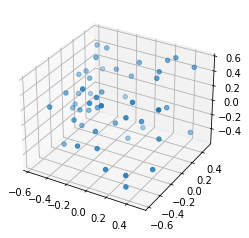

matrix P
 [[ 587.03482937  600.67313676  -10.85780279  640.        ]
 [-287.3175218   402.17452547  679.14673874  640.        ]
 [   0.63423333   -0.18005342    0.75188353    2.5       ]]
invAP
 [[ 0.53083887  0.80845852 -0.25417498  0.        ]
 [-0.56210157  0.56033525  0.60833069 -0.        ]
 [ 0.63423333 -0.18005342  0.75188353  2.5       ]]
lower_line
 [[0, 0, 0, 1]]
G0
 [[ 0.53083887  0.80845852 -0.25417498  0.        ]
 [-0.56210157  0.56033525  0.60833069 -0.        ]
 [ 0.63423333 -0.18005342  0.75188353  2.5       ]
 [ 0.          0.          0.          1.        ]]


In [204]:
### test same as italian
data = (np.random.uniform(size=(numberOfPoints,3))-0.5)/(math.sqrt(3)/2)
x = data[:,0]
y = data[:,1]
z = data[:,2]
xr = np.reshape(x,(len(x),1))
yr = np.reshape(y,(len(y),1))
zr = np.reshape(z,(len(z),1))

plot_3d(x,y,z)
A = true_K
P = rcam(A)
print("matrix P\n",np.matrix(P))
invAP = np.linalg.inv(A) @ P
print("invAP\n",invAP)
lower_line = [[0,0,0,1]]
print("lower_line\n",lower_line)
G0 = np.concatenate((invAP, lower_line),axis=0)
print("G0\n",np.matrix(G0))


In [260]:
x,y,z = p3t(G0,xr,yr,zr)
P = A @ np.concatenate((np.identity(3), np.zeros((3,1))),axis=1)
# print("P\n",P)
# print(x)
# print(conver_to_col(x))
u,v = projf(P,conver_to_col(x),conver_to_col(y),conver_to_col(z))

imagePoints[:,0,0] = u
imagePoints[:,1,0] = v
PPMGT[:,:,0] = P

print("u\n",u)
print("v\n",v)

P
 (3, 4)
c3d
 (50, 3)
h3d
 (4, 50)
h2d.shape
 (3, 50)
h2d
 [[ 383.69386359  997.59740065  357.11273364  387.13626338  712.3220197
   211.92940913  403.21264368  506.91234271  777.54055769 1158.10633771
   426.96451727  865.85474389  578.92560329  500.8608908   672.67925734
   510.1388324   953.26411046   95.80753029  618.63399816  858.46475049
   464.27899499  232.54981325  900.38469067  748.04739816  459.46046473
   509.43473341  818.79032664  358.61161015  719.10963235  572.85380955
   620.02829119  340.11461082 1183.53882022  254.38494821  817.40833813
   524.51549246  759.91159097  264.99054559  579.3466756   347.45695129
   715.87684536  369.13185598  387.00232739  301.34401019 1057.50168219
   323.96151945  397.43167542  379.93469193  630.27847232  464.12965059]
 [ 821.10100277 1090.13255199  722.72700413  717.23299326  129.90519933
   360.29062371 1001.30395453  828.54509268  961.75028401  407.42765253
   662.59287054  931.34063226  596.1904106   812.82287578 1032.86464303
  11

P
 (3, 4)
c3d
 (50, 3)
h3d
 (4, 50)
h2d.shape
 (3, 50)
h2d
 [[ 505.32694295 1085.09084346  386.44876075  999.50369589  514.56272165
   186.15985584  654.52115887  724.54398758  750.2687828   402.07249563
   459.98396342 1043.10363648  828.54517534  412.99151727  783.40416922
   928.11752176  715.17740669  647.45085824  942.41163077  229.89083486
   591.13777299  507.22115375 1061.59025954 1120.19960393  692.1131998
   480.29457445  627.40941619  345.60673215  186.15802376  877.96663081
  1005.31279438  537.18021416 1065.30059887  644.11346958  955.08430358
   309.68160175  432.31247738  547.09857681  501.43877649  856.29488122
   718.65837351  505.15038546  453.05173307  989.23807191 1117.30952755
   402.99850422  916.88980642  598.5074779   568.26435324  695.64141392]
 [ 202.85109947  711.96294417  206.2979696   635.37003317 1117.66495184
   345.05076764  132.43797473  419.69267308  477.91572293 1053.00394359
   360.5627215   758.77007785  768.80387073  226.24233605  360.22352056
   2

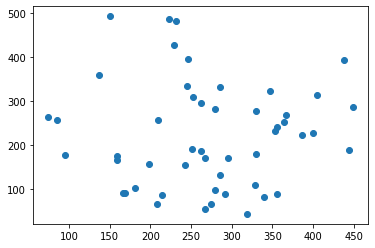

P
 (3, 4)
c3d
 (50, 3)
h3d
 (4, 50)
h2d.shape
 (3, 50)
h2d
 [[ 514.26872231 1214.99989565  403.08107077  727.47241051  416.82113536
    90.94729347  668.6819041   689.3958072   887.03279409  685.86634927
   451.94943812 1067.87516922  688.94496102  522.00459453  879.31058253
   917.39706996  839.4286618   404.81456602 1011.09730286  472.06375338
   546.46303096  265.26269741 1116.61597689  945.31103142  726.71134894
   285.84982492  624.89586508  307.2980642   347.12126095  969.2588877
   850.93823284  452.60913338 1268.17744251  526.43398455 1057.53039497
   163.71203581  642.32867253  387.63213641  500.44464055  643.36475115
   682.95746979  319.47820644  232.83715895  737.79569063 1268.51348838
   382.59562993  717.42101354  430.22752985  753.28999395  704.26469712]
 [ 297.07616183  695.57734985  327.96695582  397.16401077 1013.22878794
   416.52060457  210.8876525   412.87168605  564.45204528 1216.49527519
   430.5630102   678.63433597  627.03622902  397.2206388   431.75701009
   2

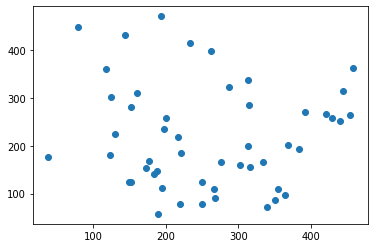

P
 (3, 4)
c3d
 (50, 3)
h3d
 (4, 50)
h2d.shape
 (3, 50)
h2d
 [[ 787.44443308 1118.24097712  684.83907087  719.89015467  151.99597857
   318.69987548  969.26029544  816.03801432  961.3580678   436.89190809
   636.71877486  956.37886915  606.3046003   781.21422935 1024.37340736
  1134.34600002  680.81191859  679.78656406 1223.76809812  460.97075573
   670.67853727  342.36425667 1015.11067072  696.37328094 1002.87102481
   103.75541281  409.61753326  494.16424293  365.16769982 1250.44060315
   748.74536195  646.71460071 1057.81904015  801.47860061 1092.69357103
   -12.41199385  755.61589087  560.76800668  530.18065784  729.00446109
   564.03644106  320.66582697  147.17191211  857.65530487 1142.8297805
   652.64126198  782.11519652  471.17211928 1018.87475309  937.43884393]
 [ 373.03581328  804.59714941  298.90081339 1098.80961895  857.01365173
   345.58124903  424.81029133  630.15098183  508.60690052  409.37059666
   428.15148317  897.97912223  932.14251077  236.20267778  517.03636238
   6

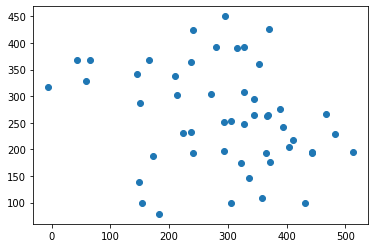

P
 (3, 4)
c3d
 (50, 3)
h3d
 (4, 50)
h2d.shape
 (3, 50)
h2d
 [[ 215.17328751  689.68006271  227.93641658  586.89775676 1116.98748248
   371.68649757  134.54222301  411.51234085  481.63237172 1091.91444722
   374.19533028  730.80649063  743.11174188  253.38771398  358.65113999
   212.14023255  878.9800983   195.52465185  210.81045823  737.91316992
   447.11703609  557.92512847  707.89900652  955.03326951  165.21332975
   993.26255867 1002.0291954   399.18928257  704.73489135  110.05941458
   735.67282099  345.68620843  878.95071942  188.07694106  501.65146999
  1019.73555421  485.66374311  383.2049716   622.62038468  460.84639177
   822.35512096  681.33222303  840.46962866  375.45267374  729.05506267
   246.02765385  480.84362824  592.26328288  201.81791273  237.75120127]
 [ 728.96531283  651.68516439  782.93097786  133.09741844  521.27738378
   693.31693129  685.88354212  574.24963263  798.45197386 1093.10678921
   712.31511508  519.04898609  370.19977109  899.45729843  737.26107097
   

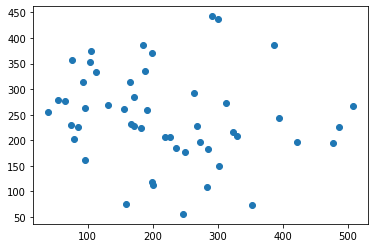

In [258]:
for view in range (1,numberOfViews):

    #   % random camera position
    P = rcam(A)

    #   % apply world coordinate transformation
    P = P @ np.linalg.inv(G0);

    #   % project world points to image points
    u,v = projf(P,conver_to_col(x),conver_to_col(y),conver_to_col(z))

    #   % add noise to image points
    #       u = u + sigma * randn(size(u));
    #       v = v + sigma * randn(size(v));

    imagePoints[:,0,view] = u
    imagePoints[:,1,view] = v

    PPMGT[:,:,view] = P   
    plot_2d(u,v)

In [268]:

for i in range(numberOfViews):
    for j in range(i+1,numberOfViews):
        Fs[:,:,i,j] = calc_fund_matrix(imagePoints[:,:,i],imagePoints[:,:,j])

In [272]:
initial_K =  [true_K[0,0], true_K[0,2],true_K[1,1],true_K[1,2]]
res = opt.minimize(mendonca_cost_func,x0=initial_K, method='Nelder-Mead')

In [273]:
result_K = np.zeros((3,3))
result_K = np.array([[res.x[0],0,res.x[1]],[0,res.x[2],res.x[3]],[0,0,1]])
print (np.matrix(result_K))

[[800.2885795    0.         256.0010802 ]
 [  0.         800.28578167 256.00230876]
 [  0.           0.           1.        ]]


In [70]:
eyep = np.random.uniform(size=(1,3))-0.5
print(eyep)

[[ 0.45586612 -0.11839313 -0.26747562]]


In [108]:
def randomize_rt():
    angle = np.random.uniform(0,45)
    cos =  math.cos(angle)
    sin =  math.sin(angle)
#     t = np.random.randint(-5,5,(3,1))
    t = np.zeros((3,1))
    t[2] = 1
    t = np.zeros((3,1))
    R = np.array([[cos,-sin,0],[sin,cos,0],[0,0,1]])
    Rt = np.concatenate((R,t),axis=1)
    print(Rt)
    low_row = np.zeros((1,4))
    low_row[:,-1] = 1
    Rt = np.concatenate((Rt,low_row),axis=0)
#     lowes_row = np.array([0,0,0,1])
#     Rt = np.concatenate((Rt,lowes_row),axis=0)
    print (np.matrix(Rt))
    return Rt

In [109]:
rt = randomize_rt()


[[ 0.61760802 -0.78648607  0.          0.        ]
 [ 0.78648607  0.61760802  0.          0.        ]
 [ 0.          0.          1.          0.        ]]
[[ 0.61760802 -0.78648607  0.          0.        ]
 [ 0.78648607  0.61760802  0.          0.        ]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]


In [110]:
def randomize_3d_points(num_of_points):
    world_points = np.random.uniform(-1,1,(num_of_points,3))
    return world_points

def get_projection_of_points(world_points):
    world_points_hom = projectivation(world_points)
    return world_points_hom

In [111]:
world_points = randomize_3d_points(N)
T1 = normalization_matrix(world_points)
world_points_hom = get_projection_of_points(world_points)

In [112]:
world_points_hom.shape

(8, 4)

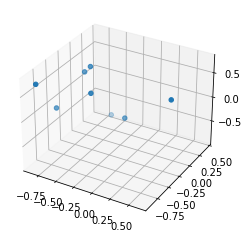

In [113]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(world_points[:,0],world_points[:,1],world_points[:,2])
plt.show()

In [95]:
(world_points_hom[0])

array([-0.46411482, -0.41598973,  0.07596925,  1.        ])

In [122]:
image0_p0 = np.zeros(3)
rt = randomize_rt()
k_extended = np.concatenate((true_K,np.zeros(shape=(3,1))),axis=1)
print(k_extended)
image0_p0 = k_extended @ world_points_hom[0]

[[-0.37738114 -0.92605803  0.          0.        ]
 [ 0.92605803 -0.37738114  0.          0.        ]
 [ 0.          0.          1.          0.        ]]
[[-0.37738114 -0.92605803  0.          0.        ]
 [ 0.92605803 -0.37738114  0.          0.        ]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]
[[5. 0. 2. 0.]
 [0. 5. 2. 0.]
 [0. 0. 1. 0.]]


In [123]:
image0 = np.zeros((N,3))
for i in range(N):
    image0[i,:] = true_K @ I @ world_points_hom[i]
    image0[i,:] = image0[i,:]/image0[i,-1]

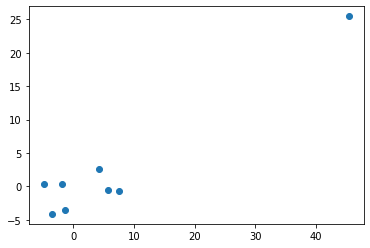

In [124]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(image0[:,0],image0[:,1])
plt.show()

In [127]:
projected = np.zeros((n_images,N,3))

for image in range(n_images):
    if (image == 0): # use the first image as it was not rotated
#         rt = I
        rt = np.identity(4)
    else:
        rt = randomize_rt()
    print (np.matrix(rt))
    for point in range(N):
#         projected[image,point,:] = true_K @ rt @ world_points_hom[point]
        projected[image,point,:] = k_extended @ rt @ world_points_hom[point]
        projected[image,point,:]/= world_points[point,-1]


[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[[-0.91804415 -0.39647817  0.          0.        ]
 [ 0.39647817 -0.91804415  0.          0.        ]
 [ 0.          0.          1.          0.        ]]
[[-0.91804415 -0.39647817  0.          0.        ]
 [ 0.39647817 -0.91804415  0.          0.        ]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]
[[-0.91804415 -0.39647817  0.          0.        ]
 [ 0.39647817 -0.91804415  0.          0.        ]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]
[[ 0.19822539 -0.98015646  0.          0.        ]
 [ 0.98015646  0.19822539  0.          0.        ]
 [ 0.          0.          1.          0.        ]]
[[ 0.19822539 -0.98015646  0.          0.        ]
 [ 0.98015646  0.19822539  0.          0.        ]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]
[[ 0.19822539 -0

In [128]:
print(projected)

[[[ -1.81056428   0.41366764   1.        ]
  [  7.62226971  -0.70287223   1.        ]
  [  5.72728295  -0.45891338   1.        ]
  [ 45.33854542  25.44566969   1.        ]
  [ -3.40831338  -4.10639453   1.        ]
  [  4.25546139   2.59252799   1.        ]
  [ -1.38889483  -3.5731037    1.        ]
  [ -4.76757776   0.4294614    1.        ]]

 [[  6.12721239   1.94551758   1.        ]
  [ -2.08986196   6.71046326   1.        ]
  [ -0.44690482   5.73517737   1.        ]
  [-47.08239431  -2.34137255   1.        ]
  [  9.3861226    5.46166156   1.        ]
  [ -0.30553755   2.35027436   1.        ]
  [  7.32076904   5.77273241   1.        ]
  [  8.83561943   0.75862691   1.        ]]

 [[  2.79950332  -2.04940056   1.        ]
  [  5.76371431   6.97492609   1.        ]
  [  5.14896197   5.16590141   1.        ]
  [-12.38962455  49.1260825    1.        ]
  [  6.91315703  -4.51143576   1.        ]
  [  1.86631958   4.32815916   1.        ]
  [  6.79074861  -2.42637784   1.        ]
  [  2.

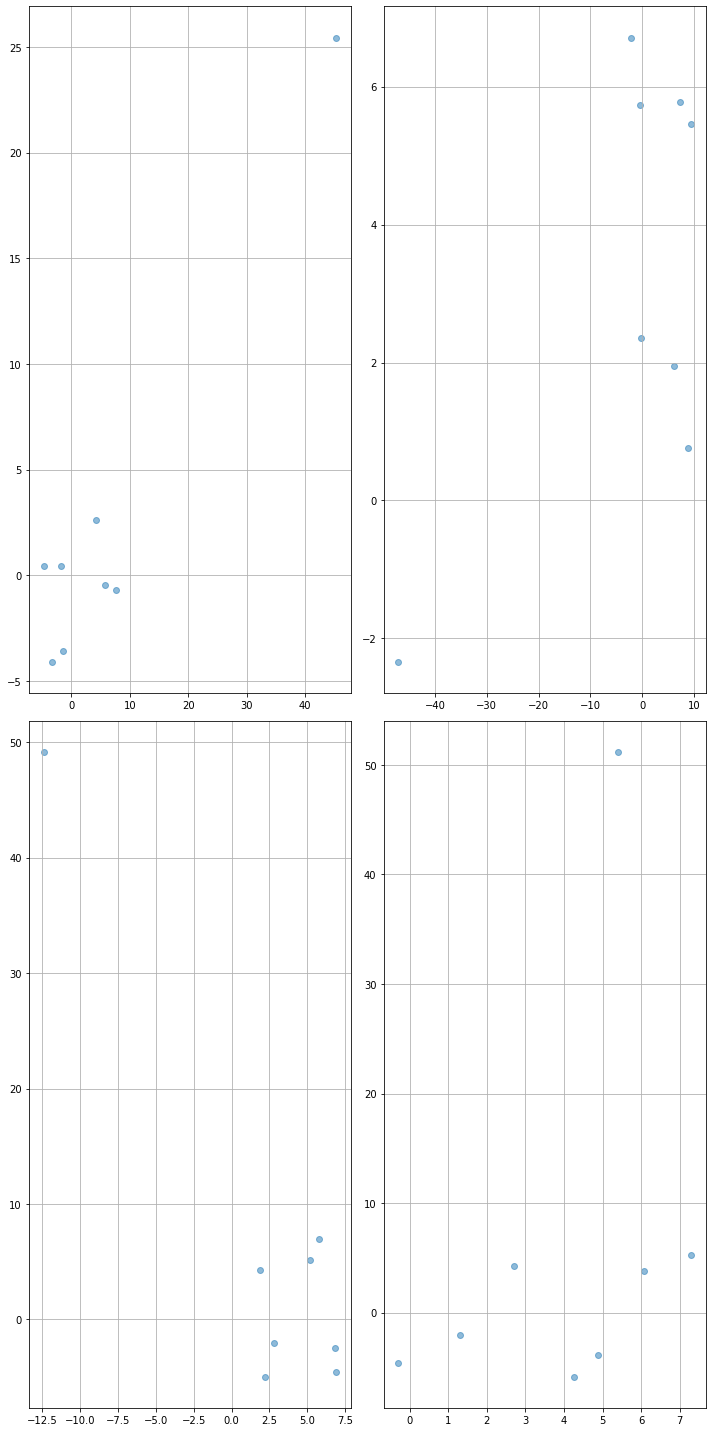

In [129]:
fig, axes = plt.subplots(2, 2, figsize=(10,20))

for i, ax in enumerate(axes.ravel()):
    ax.scatter(projected[i,:,0],projected[i,:,1], alpha=.5)
    ax.grid()
    
plt.tight_layout()

In [130]:
for i in range(n_images-1):
    for j in range(i+1,n_images):
        F[i,j] = calc_fund_matrix(projected[i,:,0:2],projected[j,:,0:2])

In [131]:
np.matrix(F[0,1])

matrix([[ 0.00373795, -0.00865523, -0.07349299],
        [ 0.00865522,  0.00373797, -0.21681532],
        [-0.0251494 , -0.19949414,  1.        ]])

In [132]:
for i in range(n_images-1):
    for j in range(i+1,n_images):
        print(i,j)
        print(np.matrix(F[i,j]))

0 1
[[ 0.00373795 -0.00865523 -0.07349299]
 [ 0.00865522  0.00373797 -0.21681532]
 [-0.0251494  -0.19949414  1.        ]]
0 2
[[ 1.33045397  0.26906832 -0.36646844]
 [-0.26906907  1.33045353 -0.85782837]
 [-3.92409929 -0.6734168   1.        ]]
0 3
[[ 0.01817928  0.01152135 -0.38967686]
 [-0.01152134  0.01817928 -0.02690057]
 [ 0.17495857 -0.33109826  1.        ]]
1 2
[[ 0.2657794  -0.05612958 -0.81724114]
 [ 0.0561296   0.26577941 -0.3675555 ]
 [-0.29129048 -0.08703055  1.        ]]
1 3
[[ 0.13173457  0.02088067  0.42949415]
 [-0.0208807   0.13173458 -0.26701247]
 [-0.15143166 -1.03798827  1.        ]]
2 3
[[ 0.0324529  -0.08484453  1.38559679]
 [ 0.08484453  0.0324529  -0.22782667]
 [-1.42846501 -0.35911667  1.        ]]


In [133]:
initial_K =  np.random.randint(-5,5,(5))
res = opt.minimize(mendonca_cost_func,x0=initial_K, method='Nelder-Mead')
# res = opt.minimize(mendonca_cost_func,x0=initial_K)

In [134]:
res

 final_simplex: (array([[ 0.01296455, -1.22789579, -1.72413054,  3.45186497,  1.25064715],
       [ 0.01296408, -1.22790443, -1.72403546,  3.45179599,  1.2505588 ],
       [ 0.01296414, -1.22789546, -1.72406032,  3.45177905,  1.25057003],
       [ 0.01296421, -1.22788189, -1.72403711,  3.45176823,  1.25061603],
       [ 0.0129641 , -1.22789038, -1.72405468,  3.45181789,  1.25059031],
       [ 0.01296403, -1.22792695, -1.72405391,  3.45178648,  1.25055853]]), array([2.20428958, 2.20428958, 2.20428958, 2.20428958, 2.20428958,
       2.20428958]))
           fun: 2.2042895767094866
       message: 'Optimization terminated successfully.'
          nfev: 331
           nit: 200
        status: 0
       success: True
             x: array([ 0.01296455, -1.22789579, -1.72413054,  3.45186497,  1.25064715])

In [135]:
result_K = np.zeros((3,3))
result_K = np.array([[res.x[0],res.x[1],res.x[2]],[0,res.x[3],res.x[4]],[0,0,1]])
print (np.matrix(result_K))

[[ 0.01296455 -1.22789579 -1.72413054]
 [ 0.          3.45186497  1.25064715]
 [ 0.          0.          1.        ]]


In [136]:
print(np.matrix(true_K))

[[5 0 2]
 [0 5 2]
 [0 0 1]]


In [137]:
image0_p0/image0_p0[2]

array([-1.81056428,  0.41366764,  1.        ])

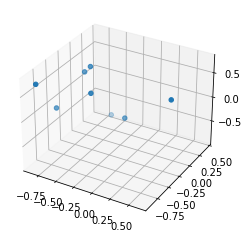

In [138]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(world_points[:,0],world_points[:,1],world_points[:,2])
plt.show()

In [139]:
# EXPERIMENT

# array of n_images with original coordinates of N points (x,y)
p = np.zeros((n_images,N,2))
# array of n_images with projective coordinats of M points (x,y,1)
pj = np.zeros((n_images,N,3))

# randomly initialize 1st image (index #0)
p[0] = np.random.randint(0,500,(N,2))
pj[0] = projectivation(p[0])

#init random matrices to transform original image
A = np.random.randint(-6,6,(n_images-1,3,3))
A[:,] = np.triu(A[:,])
# transform original image to get new images 
for i in range(1,n_images):
    pj[i] = (A[i-1]@pj[0].T).T
    p[i] = affinization(pj[i])
   
# insert noise
noise_level1 = 0.25
for i in range(n_images):
    p[i] += noise_level1*np.random.randn(N,2)

<ipython-input-5-954e64988e5a>:20: RuntimeWarning: divide by zero encountered in true_divide
  p = q[:,0:d]/q[:,d:d+1]


In [140]:
print (A[0])

[[-6 -5  4]
 [ 0 -2 -1]
 [ 0  0  5]]


In [141]:
print (p.shape)

(4, 8, 2)


In [142]:
for i in range(n_images-1):
    for j in range(i+1,n_images):
        F[i,j] = calc_fund_matrix(p[i],p[j])

In [143]:
initial_K =  np.random.randint(-5,5,(5))

In [144]:
res = opt.minimize(mendonca_cost_func,x0=initial_K, method='Nelder-Mead')

LinAlgError: SVD did not converge

In [145]:
print (res)

 final_simplex: (array([[ 0.01296455, -1.22789579, -1.72413054,  3.45186497,  1.25064715],
       [ 0.01296408, -1.22790443, -1.72403546,  3.45179599,  1.2505588 ],
       [ 0.01296414, -1.22789546, -1.72406032,  3.45177905,  1.25057003],
       [ 0.01296421, -1.22788189, -1.72403711,  3.45176823,  1.25061603],
       [ 0.0129641 , -1.22789038, -1.72405468,  3.45181789,  1.25059031],
       [ 0.01296403, -1.22792695, -1.72405391,  3.45178648,  1.25055853]]), array([2.20428958, 2.20428958, 2.20428958, 2.20428958, 2.20428958,
       2.20428958]))
           fun: 2.2042895767094866
       message: 'Optimization terminated successfully.'
          nfev: 331
           nit: 200
        status: 0
       success: True
             x: array([ 0.01296455, -1.22789579, -1.72413054,  3.45186497,  1.25064715])


In [146]:
result_K = np.zeros((3,3))
result_K = np.array([[res.x[0],res.x[1],res.x[2]],[0,res.x[3],res.x[4]],[0,0,1]])
print (np.matrix(result_K))

[[ 0.01296455 -1.22789579 -1.72413054]
 [ 0.          3.45186497  1.25064715]
 [ 0.          0.          1.        ]]


In [ ]:
#reconststruction

#find Fundamental matrix
F12 = np.zeros((3,3))
F12 = calc_fund_matrix(p[0],p[1])

#find Essential matrix
EM = result_K.T @ F @ result_K

#factorize EM to find R,t
U,D,Vt = np.linalg.svd(EM)

In [ ]:
randomize_rt()